In [1]:
# Install necessary packages
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install mlxtend  # Untuk algoritma association rule jika diperlukan

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Base libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# TRANSACTION ENCODER
from mlxtend.preprocessing import TransactionEncoder

# APRIORI FUNCTION
from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
# Setup configuration
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style="whitegrid", palette="deep", font_scale=0.9, color_codes=True)

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Constants
DATA_RAW_DIR = './data/raw/'  # Folder untuk menyimpan data mentah

In [4]:
# Load data
data = pd.read_csv('../' + DATA_RAW_DIR + 'Retail_Transaction_Dataset.csv')

## Understand the retail transaction data

In [5]:
# Display information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          100000 non-null  int64  
 1   ProductID           100000 non-null  object 
 2   Quantity            100000 non-null  int64  
 3   Price               100000 non-null  float64
 4   TransactionDate     100000 non-null  object 
 5   PaymentMethod       100000 non-null  object 
 6   StoreLocation       100000 non-null  object 
 7   ProductCategory     100000 non-null  object 
 8   DiscountApplied(%)  100000 non-null  float64
 9   TotalAmount         100000 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 7.6+ MB


In [6]:
# Display 3 first rows, 4 middle rows, and 3 last rows of the data
middle_index = len(data) // 2

head_data = data.head(3)
middle_data = data.iloc[middle_index:middle_index+4]
tail_data = data.tail(3)

pd.concat([head_data, middle_data, tail_data])

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
50000,909517,B,2,26.111729,1/25/2024 4:08,PayPal,"8344 Walsh Views\nGoldenside, OH 42445",Home Decor,0.093433,52.174665
50001,653691,C,8,99.726321,3/4/2024 11:57,Credit Card,"9942 Garcia Causeway Apt. 601\nDonnaborough, G...",Books,8.636191,728.910118
50002,644016,D,2,67.592974,7/18/2023 16:26,PayPal,"PSC 8780, Box 5179\nAPO AP 13157",Clothing,14.537350,115.533495
50003,385617,D,7,43.697889,5/10/2023 2:10,PayPal,"63359 Joshua Fields\nGeorgeborough, NJ 68173",Books,5.402261,289.360504
99997,887304,B,4,72.385564,8/25/2023 7:59,Credit Card,"50653 Kara Lakes\nStephanieborough, RI 94492",Clothing,17.423979,239.092472
99998,326401,C,5,66.542239,2/5/2024 19:45,PayPal,"18756 Mcfarland Way Suite 866\nBarnettside, PR...",Electronics,14.345018,284.983717
99999,771566,C,5,38.087766,2/4/2024 11:53,Debit Card,"8046 Hull Drive\nPaulstad, GU 87218",Home Decor,2.966058,184.790305


### Data preparation

In [7]:
# Periksa jumlah duplikat
duplikat_count = data.duplicated().sum()
print(f"Jumlah data duplikat: {duplikat_count}")

if duplikat_count > 0:
    print("Menghapus data duplikat:")
    # Hapus duplikat
    data = data.drop_duplicates()

    # Verifikasi jumlah duplikat setelah penghapusan
    duplikat_count_after = data.duplicated().sum()
    print(f"Jumlah data duplikat setelah dihapus: {duplikat_count_after}")
else:
    print("Tidak ada data duplikat yang perlu dihapus") 


Jumlah data duplikat: 0
Tidak ada data duplikat yang perlu dihapus


In [8]:
# Periksa apakah ada nilai dalam dataset yang kosong atau NaN
missing = data.isnull().values.any()

if missing:
    print("Ada nilai yang kosong dalam dataset")
    # Tampilkan jumlah nilai yang kosong di setiap kolom
    missing_values = data.isnull().sum()
    print("Jumlah nilai kosong di setiap kolom:\n", missing_values)
    
    # Hapus baris yang mengandung nilai kosong
    data = data.dropna()
    print("Jumlah baris setelah menghapus nilai kosong:", len(data))    
else:
    print("Tidak ada nilai yang kosong dalam dataset")

Tidak ada nilai yang kosong dalam dataset


Karena pada association rule kita hanya membutuhkan data group transaksi dan productnya, maka kita akan menghapus kolom-kolom yang tidak diperlukan.

data akan di group berdasarkan customer id.

In [5]:
# Sisakan column CustomerID, TransactionDate dann ProductCategory
data = data[['CustomerID', 'TransactionDate', 'ProductCategory']]

# Tampilkan perubahan
data.head()

,CustomerID,TransactionDate,ProductCategory
0,109318,12/26/2023 12:32,Books
1,993229,8/5/2023 0:00,Home Decor
2,579675,3/11/2024 18:51,Books
3,799826,10/27/2023 22:00,Books
4,121413,12/22/2023 11:38,Electronics


In [6]:
# Ambil data transaksi yang dilakukan 9 bulan terakhir (April 2024 - Januari 2025)
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data = data[data['TransactionDate'] >= '2024-04-01']

# Menggabungkan data transaksi berdasarkan CustomerID
data = data.groupby(['CustomerID'])['ProductCategory'].apply(list).reset_index()

# Hanya ambil data yang memiliki product category lebih dari 1
data = data[data['ProductCategory'].apply(len) > 1]

# Tamplikan data
data.head()

,CustomerID,ProductCategory
34,3720,"[Electronics, Home Decor]"
114,14506,"[Electronics, Electronics]"
305,40915,"[Books, Home Decor]"
350,46364,"[Clothing, Books]"
480,64433,"[Books, Clothing]"


In [7]:
# Sisakan column ProductCategory
product_category = data['ProductCategory']

# Tampilkan data
print(product_category.head())

34      [Electronics, Home Decor]
114    [Electronics, Electronics]
305           [Books, Home Decor]
350             [Clothing, Books]
480             [Books, Clothing]
Name: ProductCategory, dtype: object


In [8]:
# Ensure all entries are strings and split if necessary
splittedData = product_category.apply(
    lambda x: x if isinstance(x, list) else x.split(',')
)

# Transform data using TransactionEncoder
te = TransactionEncoder()
te_data = te.fit(splittedData).transform(splittedData)

# Create a DataFrame from the transformed data
df = pd.DataFrame(te_data, columns=te.columns_).astype(int)

# Display the result
df

,Books,Clothing,Electronics,Home Decor
0,0,0,1,1
1,0,0,1,0
2,1,0,0,1
3,1,1,0,0
4,1,1,0,0
5,0,0,1,1
6,0,1,0,1
7,1,1,0,0
8,1,0,1,0
9,1,0,1,0


In [14]:
# Menemukan itemset yang sering muncul
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)
print(frequent_itemsets.head())

# Hitung jumlah itemsets (jumlah transaksi atau baris data)
num_itemsets = len(df)

# Membuat aturan asosiasi dari itemset
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5,
    num_itemsets=num_itemsets
)
print(rules.head())

    support           itemsets
0  0.461538            (Books)
1  0.410256         (Clothing)
2  0.487179      (Electronics)
3  0.487179       (Home Decor)
4  0.179487  (Clothing, Books)
     antecedents    consequents  antecedent support  consequent support  \
0   (Home Decor)  (Electronics)            0.487179            0.487179   
1  (Electronics)   (Home Decor)            0.487179            0.487179   

   support  confidence      lift  representativity  leverage  conviction  \
0  0.25641    0.526316  1.080332               1.0  0.019066    1.082621   
1  0.25641    0.526316  1.080332               1.0  0.019066    1.082621   

   zhangs_metric   jaccard  certainty  kulczynski  
0          0.145  0.357143   0.076316    0.526316  
1          0.145  0.357143   0.076316    0.526316  


In [42]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,label,confidence_category
0,(Home Decor),(Electronics),0.487179,0.487179,0.25641,0.526316,1.080332,1.0,0.019066,1.082621,0.145,0.357143,0.076316,0.526316,Low Lift,High
1,(Electronics),(Home Decor),0.487179,0.487179,0.25641,0.526316,1.080332,1.0,0.019066,1.082621,0.145,0.357143,0.076316,0.526316,Low Lift,High


Sortir aturan berdasarkan metrik yang relevan

Analisis aturan:
- Apa item yang sering muncul bersama?
- Apakah ada pola unik atau outlier?

In [15]:
rules = rules.sort_values(by="lift", ascending=False)
print(rules.head())

     antecedents    consequents  antecedent support  consequent support  \
0   (Home Decor)  (Electronics)            0.487179            0.487179   
1  (Electronics)   (Home Decor)            0.487179            0.487179   

   support  confidence      lift  representativity  leverage  conviction  \
0  0.25641    0.526316  1.080332               1.0  0.019066    1.082621   
1  0.25641    0.526316  1.080332               1.0  0.019066    1.082621   

   zhangs_metric   jaccard  certainty  kulczynski  
0          0.145  0.357143   0.076316    0.526316  
1          0.145  0.357143   0.076316    0.526316  


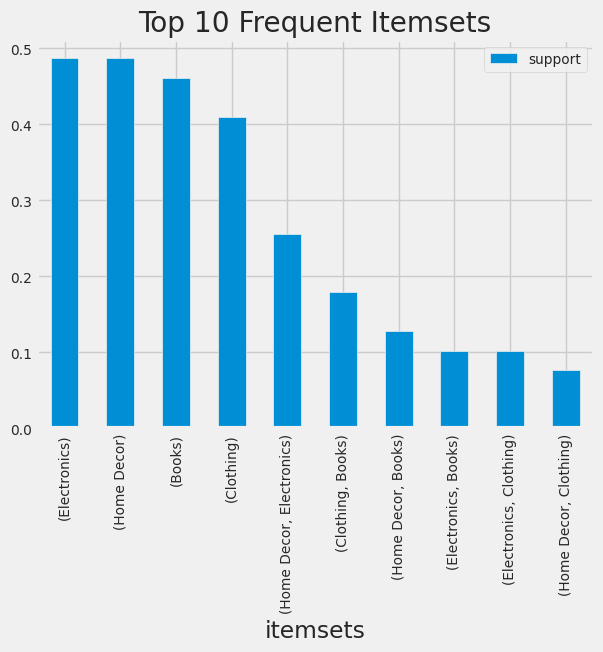

In [16]:
frequent_itemsets.sort_values(by="support", ascending=False).head(10).plot(
    kind="bar", x="itemsets", y="support", title="Top 10 Frequent Itemsets"
)
plt.show()

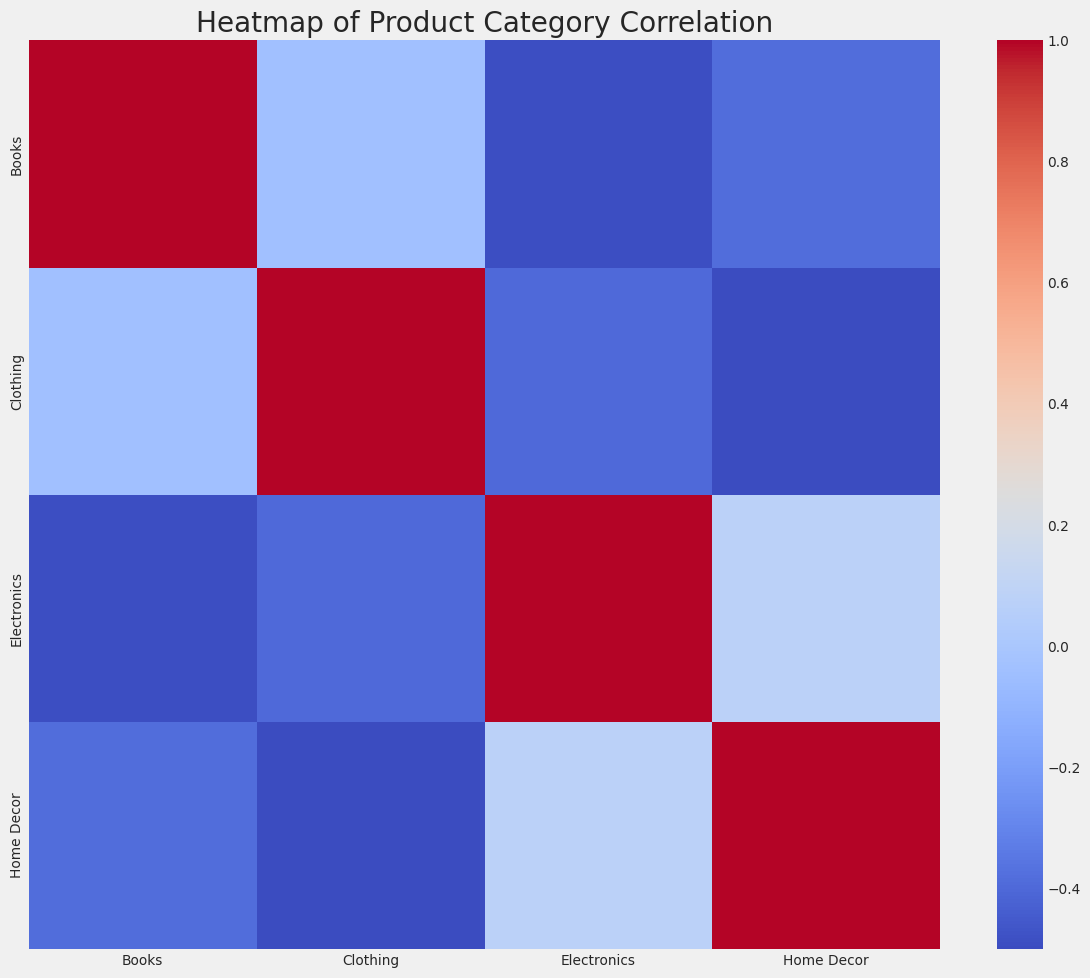

In [21]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    annot=False,
    cbar=True
)
plt.title("Heatmap of Product Category Correlation")
plt.tight_layout()
plt.show()